In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel('중간3.xlsx')

In [3]:
using_data_original = ['netizen_ratings','감독 순위','title_len','log_num_reviews','fill_num_article']
using_data_onehotencoding_pca = ['genre','released_month','companyNm_integrated']
using_data_onehotencoding_no_pca = ['country','running_time_bins','rating']

In [6]:
temp_X = df[using_data_original+using_data_onehotencoding_pca+using_data_onehotencoding_no_pca]
temp_y = df['log_num_viewers']

In [10]:
data = temp_X
data['log_num_viewers'] = temp_y
data.to_csv('final.csv',index=False)

C:\Users\hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [31]:
data = pd.read_csv('final.csv')
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge ,RidgeCV, LassoCV
from sklearn.feature_selection import SelectPercentile, f_regression, SelectFromModel
pipe_onehot_pca = Pipeline([('onehot',OneHotEncoder(sparse=False, handle_unknown='ignore'))
                            ,('pca',PCA(n_components=0.85,))
                           ])
ct = ColumnTransformer([
                    ('scaling',StandardScaler(),using_data_original),
                    ('pipe1',pipe_onehot_pca,['genre']),('pipe2',pipe_onehot_pca,['released_month']),
                    ('pipe3',pipe_onehot_pca,['companyNm_integrated']),
                    ('onehot',OneHotEncoder(sparse=False,handle_unknown='ignore'),using_data_onehotencoding_no_pca)
                    ])
# pipe_all = Pipeline([('ct',ct),('feature_select',SelectPercentile(score_func=f_regression,percentile=90)),('Linear',RidgeCV(np.arange(1,30,1)))])
pipe_all = Pipeline([('ct',ct),
                     ('feature_select',SelectPercentile(score_func=f_regression,percentile=80)),
                     ('Linear',Ridge(alpha=1))])

In [7]:
from sklearn.model_selection import cross_validate,cross_val_predict
from sklearn.model_selection import KFold
kfold = KFold(n_splits=10, shuffle=True, random_state=22)
reg1 = cross_validate(pipe_all, temp_X, temp_y,return_train_score=True, return_estimator=True, cv=kfold)
reg1['test_score'].mean()

0.7645431275301166

In [34]:
from sklearn.metrics import make_scorer, r2_score
@make_scorer
def r2_score_transform(real, pred):
    return r2_score(np.exp(real),np.exp(pred))

In [35]:
reg2 = cross_validate(pipe_all, X, y,return_train_score=True, return_estimator=True, cv=kfold, 
                     scoring=r2_score_transform)
reg2['test_score'].mean()

0.7125550348939611

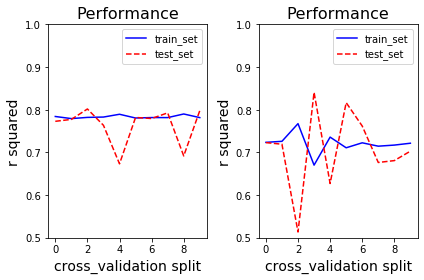

In [78]:
fig,ax = plt.subplots(1,2)
ax[0].plot(reg1['train_score'],color='blue')
ax[0].plot(reg1['test_score'],color='red',linestyle ='--')
ax[0].set_ylim([0.5,1])
ax[0].legend(['train_set','test_set'])
ax[0].set_title('Performance',fontsize=16)
ax[0].set_xlabel('cross_validation split',fontsize=14)
ax[0].set_ylabel('r squared',fontsize=14)


ax[1].plot(reg2['train_score'],color='blue')
ax[1].plot(reg2['test_score'],color='red',linestyle ='--')
ax[1].set_ylim([0.5,1])
ax[1].legend(['train_set','test_set'])
ax[1].set_title('Performance',fontsize=16)
ax[1].set_xlabel('cross_validation split',fontsize=14)
ax[1].set_ylabel('r squared',fontsize=14)

plt.tight_layout()
plt.savefig('performance.png',bbox_inches='tight')

In [14]:
for i in range(10):
    coef = reg1['estimator'][i].steps[2][1].coef_
    print(len(coef))


39
37
38
38
39
38
38
38
38
39


In [16]:
reg1['estimator'][7].steps[2][1].coef_

array([-0.04345431, -0.03093944,  0.07828884,  1.11000127,  0.10841892,
       -0.2348961 ,  0.11064298, -0.28825733, -0.18250191,  0.1297549 ,
        0.33259515, -0.11749646, -0.11627896, -0.10528144,  0.00464904,
        0.03035196,  0.05626585, -0.1010578 , -0.49832237, -0.10435907,
        0.0616921 , -0.11562272, -0.088881  ,  0.14160268,  0.10716378,
       -0.35292306,  0.14844722,  0.71829689,  0.18426483, -0.24448603,
       -0.04298135,  0.04822702, -0.10485405, -0.03932963,  0.09595666,
        0.00248365,  0.4332392 , -0.21049481])